## **Laboratorio 1: Deteccion de Phishing**

- Juan Pablo Solis
- Andres Yatmian Jo Mai

### **Parte 1: Ingeniería de características**

In [3]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from collections import Counter
from math import log2
import pandas as pd


In [ ]:

df = pd.read_csv("dataset_pishing.csv")

df.head()


,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [ ]:
conteo = df['status'].value_counts()

print("Cantidad por clase:")
print(conteo)


Cantidad por clase:
status
legitimate    5715
phishing      5715
Name: count, dtype: int64


El dataset esta balanceado al tener la misma cantidad de observaciones de phishing como legitimas.

### **Derivación de características**

- ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?

El análisis de una URL ofrece varias ventajas frente al análisis de otros datos como el tiempo de vida del dominio o las características del contenido de la página, principalmente porque permite una detección más rápida, segura y en tiempo real sin necesidad de descargar el sitio web, lo que reduce riesgos de exposición a malware y disminuye el consumo de recursos. Además, no depende de servicios externos como consultas WHOIS o DNS, lo que mejora la eficiencia y escalabilidad del sistema. Otra ventaja a mencionar es que las URl utilizadas para phishing tienen un tiempo de vida relativamente corto, por lo que la informacion que se puede obtener de ahi es irrelevante.

- ¿Qué características de una URL son más prometedoras para la detección de phishing?

Las características más prometedoras son: la longitud excesiva de la dirección, el uso de direcciones IP en lugar de nombres de dominio, la presencia y frecuencia de caracteres especiales, el número elevado de subdominios y la estructura anómala del enlace. Es bastante importante la distribución y entropía de caracteres no alfanuméricos, ya que los atacantes suelen insertar símbolos, guiones, múltiples puntos o parámetros innecesarios para simular legitimidad o redirigir al usuario. Estas propiedades léxicas permiten distinguir patrones sospechosos sin necesidad de analizar el contenido completo del sitio, lo que las convierte en indicadores sólidos para modelos de aprendizaje automático enfocados en detección basada exclusivamente en URL.

In [7]:
def url_length(url):
    return len(url)

def count_dots(url):
    return url.count('.')

def count_hyphens(url):
    return url.count('-')

def count_subdomains(url):
    domain = urlparse(url).netloc
    return domain.count('.')

def has_ip(url):
    pattern = r'http[s]?://\d+\.\d+\.\d+\.\d+'
    return int(bool(re.search(pattern, url)))

def count_special_chars(url):
    return len(re.findall(r'[^a-zA-Z0-9]', url))

def ratio_special_chars(url):
    total = len(url)
    special = count_special_chars(url)
    return special / total if total > 0 else 0

def count_digits(url):
    return sum(c.isdigit() for c in url)

def ratio_digits(url):
    total = len(url)
    digits = count_digits(url)
    return digits / total if total > 0 else 0

def shannon_entropy(url):
    prob = [float(url.count(c)) / len(url) for c in dict.fromkeys(url)]
    return -sum([p * log2(p) for p in prob])

def nan_entropy(url):
    nan_chars = re.findall(r'[^a-zA-Z0-9]', url)
    if len(nan_chars) == 0:
        return 0
    freq = Counter(nan_chars)
    prob = [v/len(nan_chars) for v in freq.values()]
    return -sum(p * log2(p) for p in prob)

def relative_entropy(url):
    freq = Counter(url)
    total = len(url)
    prob = [v/total for v in freq.values()]
    uniform_prob = 1/len(freq)
    return sum(p * log2(p/uniform_prob) for p in prob)

def has_https(url):
    return int(url.startswith("https"))

def count_parameters(url):
    return url.count('&')


def domain_length(url):
    return len(urlparse(url).netloc)


In [8]:
df['url_length'] = df['url'].apply(url_length)
df['dots'] = df['url'].apply(count_dots)
df['hyphens'] = df['url'].apply(count_hyphens)
df['subdomains'] = df['url'].apply(count_subdomains)
df['has_ip'] = df['url'].apply(has_ip)
df['special_chars'] = df['url'].apply(count_special_chars)
df['ratio_special'] = df['url'].apply(ratio_special_chars)
df['digits'] = df['url'].apply(count_digits)
df['ratio_digits'] = df['url'].apply(ratio_digits)
df['entropy'] = df['url'].apply(shannon_entropy)
df['nan_entropy'] = df['url'].apply(nan_entropy)
df['relative_entropy'] = df['url'].apply(relative_entropy)
df['https'] = df['url'].apply(has_https)
df['parameters'] = df['url'].apply(count_parameters)
df['domain_length'] = df['url'].apply(domain_length)


In [9]:
df.head()

,url,status,url_length,dots,hyphens,subdomains,has_ip,special_chars,ratio_special,digits,ratio_digits,entropy,nan_entropy,relative_entropy,https,parameters,domain_length
0,http://www.crestonwood.com/router.php,legitimate,37,3,0,2,0,7,0.189189,0,0.000000,3.787043,1.448816,0.212957,0,0,19
1,http://shadetreetechnology.com/V4/validation/a...,phishing,77,1,0,1,0,7,0.090909,17,0.220779,4.419864,1.148835,0.438117,0,0,23
2,https://support-appleld.com.secureupdate.duila...,phishing,126,4,1,4,0,19,0.150794,19,0.150794,4.753412,2.755058,0.290982,1,2,50
3,http://rgipt.ac.in,legitimate,18,2,0,2,0,5,0.277778,0,0.000000,3.461320,1.521928,0.123642,0,0,11
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate,55,2,2,2,0,10,0.181818,0,0.000000,4.097662,1.760964,0.224266,0,0,15


#### **Preprocesamiento**

In [10]:
df['status'] = df['status'].map({'legitimate': 0, 'phishing': 1})
df['status'].value_counts()


status
0    5715
1    5715
Name: count, dtype: int64

In [11]:
df = df.drop(columns=['url'])


In [13]:
df.dtypes


status                int64
url_length            int64
dots                  int64
hyphens               int64
subdomains            int64
has_ip                int64
special_chars         int64
ratio_special       float64
digits                int64
ratio_digits        float64
entropy             float64
nan_entropy         float64
relative_entropy    float64
https                 int64
parameters            int64
domain_length         int64
dtype: object

In [ ]:
# Separar características y etiqueta
X = df.drop(columns=['status'])
y = df['status']


#### **Selección de Características**

In [ ]:
# Eliminar columnas con varianza cero
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0)
selector.fit(X)

cols_con_varianza = X.columns[selector.get_support()]

X = X[cols_con_varianza]


In [ ]:
# Eliminar filas duplicadas
df = df.drop_duplicates()


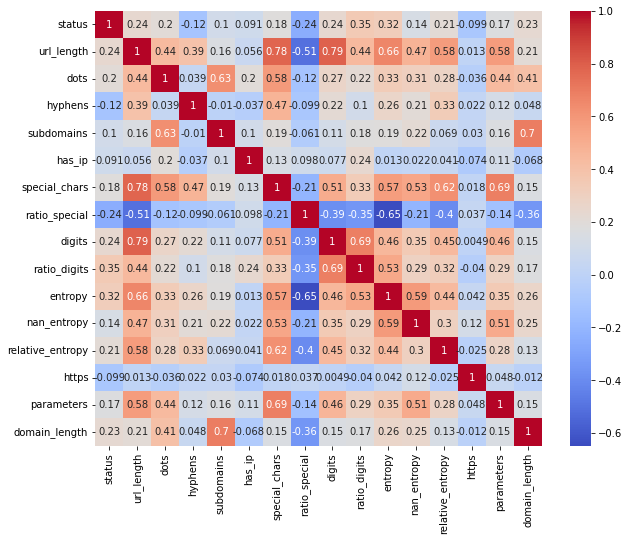

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


In [19]:
corr_status = corr['status'].sort_values(ascending=False)
print(corr_status)


status              1.000000
ratio_digits        0.348544
entropy             0.319370
digits              0.236209
url_length          0.235534
domain_length       0.229745
relative_entropy    0.210049
dots                0.202437
special_chars       0.182964
parameters          0.168634
nan_entropy         0.136184
subdomains          0.103239
has_ip              0.091031
https              -0.098991
hyphens            -0.118299
ratio_special      -0.242446
Name: status, dtype: float64


Tras el análisis exploratorio de datos se identificaron las columnas con mayor capacidad discriminativa mediante el estudio de la matriz de correlación con la variable status. Se eliminaron características con baja correlación absoluta, tales como has_ip, https y hyphens, ya que su relación con la variable objetivo fue inferior a 0.12 en valor absoluto, indicando escasa capacidad predictiva. De esta misma manera, se evaluó la posible multicolinealidad entre variables, observándose alta correlación entre entropy y relative_entropy, así como entre url_length, digits y special_chars.

Las características finalmente seleccionadas fueron: ratio_digits, entropy, digits, url_length, domain_length, dots, special_chars, parameters, nan_entropy y subdomains. Estas variables mostraron mayor correlación absoluta con la variable objetivo y capturan patrones estructurales típicos de URLs de phishing, como mayor longitud, mayor proporción de dígitos, mayor entropía y uso más frecuente de subdominios y parámetros. 

In [20]:
cols_to_drop = ['has_ip', 'https', 'hyphens', 'ratio_special', 'relative_entropy']
X = X.drop(columns=cols_to_drop)


In [21]:
print("Dimensiones después de eliminar variables:")
print(df.shape)


Dimensiones después de eliminar variables:
(10914, 16)
